In [1]:
# The notebook's environment might not recognise local installs of ADRpy, fix that now...
import os, sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..\\..\\..\\src")))

<img src="../img/ADRpy_splash.png" width="30%" align="left">

> _"Even if a final theory of physics were discovered, wonderful phenomena from turbulence to thought would still need explanation"_ <cite data-cite="weinberg1992dreams">(Weinberg, 1992).

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from ADRpy import atmospheres as at
from ADRpy import mtools4acdc as actools
from ADRpy import unitconversions as uc

# ADRpy models - Stochastic Atmospheres

The physics and the chemistry of the atmosphere are governed by laws and boundary conditions that resolve themselves into an extremely complicated picture in the latitude-longitude-altitude-time domain. This is true almost regardless of which variable field(s) we might need to understand. Temperature, flow speed, pressure, etc. all feature turbulence at various scales and are notoriously difficult to describe, and even harder to model (which is what Nobel-laureate physicist Steven Weinberg alludes to in the above quote).

Simplified models are thus required and the type of model to be used is determined by the purpose of the simulation, by the time and spatial scales that need to be resolved and by the computational resources available. For example, if Earth's climate is to be rolled back virtually over a period of 20,000 years, paleoclimatologists will conduct numerical simulations over an atmosphere coarsely discretised into a few tens of layers and a similar number of latitude and longitude steps. Similar, but much higher resolution approximations of the atmosphere, requiring thousands of CPU hours to compute (across multiple parallel processors) are used in weather forecasting.

Aircraft engineering adopts a two-stage modelling approach, which neatly reduces the complexity of the modelling problem.

1. All atmospheric conditions over space (latitude and longitude) and time (in terms of temperature, pressure and density) are collapsed onto a **single, altitude-domain profile** of these variables, which is **assumed to be representative of the environment** where the aircraft will operate. This may be the *International Standard Atmosphere (ISA)* or some other analytically or numerically defined atmosphere. Unlike the atmosphere models of climate scientists and meteorologists, these models usually can be evaluated without significant computational effort. 

2. The design calculations are generally first made on the assumption that the aircraft will fly in the idealised conditions of one such atmosphere. Subsequently, to account for the most salient aspects of the differences between this and the *real* atmospheric conditions where the aircraft is expected to operate, the design is either a) verified against a set of *off-design atmospheres*, which represent extreme conditions the aircraft may encounter during its service life or b) the design process is repeated with a probabilistic input, consisting of an *ensemble* of atmospheres, resulting in a probabilistic output (confidence intervals on aircraft performance figures). 
 

## ISA: A Simple, Analytical Model

The beauty of the International Standard Atmosphere (ISA) lies in its simplicity - its temperature profile is made up of linear segments:

<img src="../img/isa.png" width="25%" align="left">

### Temperature profile

The ISA model approximates atmospheric temperatures with a piecewise-linear model consisting of five $a_i+b_iH$ lines (where $H$ is the altitude and $i=1,\dots,5$). The first covers the troposphere, with the base temperature (at the zero level) set at $15^\mathrm{o}\mathrm{C}$ ($288.15\mathrm{K}$) and the temperature decaying at a *lapse rate* of $-6.5\times10^{-3}\mathrm{K/m}$. A turning point to a constant temperature layer (zero lapse rate, $-56.5^\mathrm{o}\mathrm{C}$ ($216.65\mathrm{K}$) marks the beginning of the stratosphere, which is split into four sub-layers. The layer base heights and ceilings, as well as the corresponding intercepts $a_i$ and slopes $b_i$ are listed in the table below:

\begin{array}{cc} \hline
                     &\mathrm{Level}& \mathrm{Layer}& \mathrm{Layer}& \mathrm{Intercept}  & \mathrm{Slope}\\
                     &\mathrm{no.}& \mathrm{base}& \mathrm{ceiling}& a_i&b_i \\
                     &i& \mathrm{(m)}& \mathrm{(m)}& \mathrm{(K)}   & \mathrm{(K/m)}\\ \hline  
\mathrm{Troposphere} & 1& 0      & 11,000 & 288.15 & -6.5\times10^{-3}   \\ \hline
\mathrm{Stratosphere}&2 & 11,000 & 20,000 & 216.65 & 0 \\
                     & 3& 20,000 & 32,000 & 196.65 & 10^{-3}  \\ 
                     & 4& 32,000 & 47,000 & 139.05 & 2.8\times10^{-3}  \\ 
                     & 5& 47,000 & 50,000 & 270.65 & 0\\ \hline
\end{array}

The function `isatemp_k` below implements this temperature model. It has two arguments, both defaulting to zero: the altitude in meters and an offset temperature in degrees (K or C). The latter simply offsets the temperature curve up or down, resulting in an *off-standard* atmosphere. This is a somewhat crude, but expeditious way of accounting for 'real' days that are colder or warmer than ISA. Aircraft performance charts are often drawn in terms of such offsets (e.g., take-off performance curves shown for ISA-10$^\mathrm{o}$C, ISA-5$^\mathrm{o}$C, ISA, ISA+5$^\mathrm{o}$C, etc.).

In [3]:
def isatemp_k(altitude_m=0, offset_deg=0):

    # Level altitudes in m
    level1 = 11000; level2 = 20000; level3 = 32000; level4 = 47000

    # Base temperatures (in K) and lapse rates (degrees per meter)
    # for each level
    a1 = 288.15; b1 = -6.5e-3
    a2 = 216.65; b2 = 0
    a3 = 196.65; b3 = 1e-3
    a4 = 139.05; b4 = 2.8e-3
    a5 = 270.65; b5 = 0

    alt_it = np.nditer([altitude_m, None])

    for alt, t_k in alt_it:
        if alt < level1: # Troposphere, linear lapse
            t_k[...] = a1 + b1 * alt
        elif alt < level2: # Lower stratopshere, constant
            t_k[...] = a2 + b2 * alt
        elif alt < level3: # Upper stratopshere, linear rise
            t_k[...] = a3 + b3 * alt
        elif alt < level4: # Linear rise
            t_k[...] = a4 + b4 * alt
        else: # Linear rise
            t_k[...] = a5 + b5 * alt
        t_k[...] = t_k[...] + offset_deg
    return alt_it.operands[1]


An example. If the conditions at 41,000 feet are described as 'ISA + 9.4$^\circ$C' - what is the temperature? [Note: we'll use the `feet2m` conversion function from ADRpy's `unitconversions` module.]

In [4]:
altitude_ft = 41000
offset_deg = 9.4

altitude_m = uc.ft_m(altitude_ft)

temp_k = isatemp_k(altitude_m, offset_deg)
temp_c = uc.K_C(temp_k)

print(temp_c,"C")

-47.099999999999966 C


A method very similar to the one shown above is integrated into a more generic atmosphere model in ADRpy's `atmospheres` module (alongside `_isapress_pa` and `_isadens_kgpm3`, ISA models of pressure and density respectively), though these functions are not public. The correct and much more convenient way of accessing them is by creating an `Atmosphere` class object, which is what we are going to discuss next.

## A more generic implementation: the *Atmosphere* class

The `atmospheres` module contains the definition of a class called `Atmosphere`. This implements the ISA, offset ISAs, as well as allowing the construction of other atmospheres through interpolation (more on which shortly).

An `Atmosphere` object can be created by instantiating the class with zero, one or two arguments. This is what the heading of the `__init__` method looks like:

`__init__(self, offset_deg=0, profile=None)`

If no arguments are passed, the object will become a basic ISA. If an `offset_deg` is specified, the temperature profile of the atmosphere will be offset by this temperature value. If a `profile` is specified, the object will be a non-ISA atmosphere defined by it (more on `profile` objects shortly). 

So here is how a basic, zero offset ISA object called `isa` can be created:

In [5]:
isa = at.Atmosphere()

This object is now equipped with all the methods of the `Atmosphere` class. Most of these take an altitude value in meters or an array of such values. For example, to calculate the temperature in C at an altitude of 1km call:

In [6]:
altitude_m = 1000

press_pa = isa.airpress_pa(altitude_m)
press_mbar = uc.Pa_mbar(press_pa)

print(press_mbar)

898.74554058789


Two other methods require an airspeed (m/s), as a first argument (followed by the altitude in m): `mach` (which returns the Mach number at that speed and altitude) and `dynamicpressure_pa` (returns dynamic pressure in Pa). Note that both arguments must be scalars when an airspeed is required.

To get a list of all the available methods, in most IDEs (and in Jupyter) you can press < Tab > after '`isa.`' - alternatively, you can look up the definition of the `Atmosphere` class in the ADRpy documentation at https://adrpy.readthedocs.io.

Let us now plot the values returned by some of these methods, against a (vertical) altitude axis. For this we will need `numpy` (to generate the equally spaced altitude values), the `unitconversions` module, and two plotting modules: `matplotlib` and `mtools4acdc` (the latter, included in ADRpy, based on the former).

Generate the vertical axis (in meters and in feet - use whichever you prefer):

In [7]:
altaxis_m  = np.arange(0, 50000, 500)
altaxis_ft = uc.m_ft(altaxis_m)

We can now send this axis as an argument to the temperature (C), speed of sound (m/s), air pressure (Pa) and air density (kg/m$^3$) methods attached to our `isa` object of the `Atmospheres` class:

In [8]:
t_isa_c = isa.airtemp_c(altaxis_m)
vs_isa_mps = isa.vsound_mps(altaxis_m)
p_isa_mbar = isa.airpress_mbar(altaxis_m)
rho_isa_kgpm3 = isa.airdens_kgpm3(altaxis_m)

We have four things to plot, all against altitude. The `panelplot_with_shared_y` method does just that. It also allows us to set axis ranges, labels, as well as to add some horizontal reference lines - in this case we will use them to mark the location of the tropopause and the stratopause (according to the ISA).

A quick implementation note: you may need to run the cell below twice in the first instance, because LaTeX requires two passes to render the graph labels correctly. If the cell below throws an error message, there may be an issue with your LaTeX installation (perhaps it is missing altogether) - if this is the case, simply set `use_tex = False` below (if you are still getting an error, run the cell again). 

In [9]:
use_tex = False

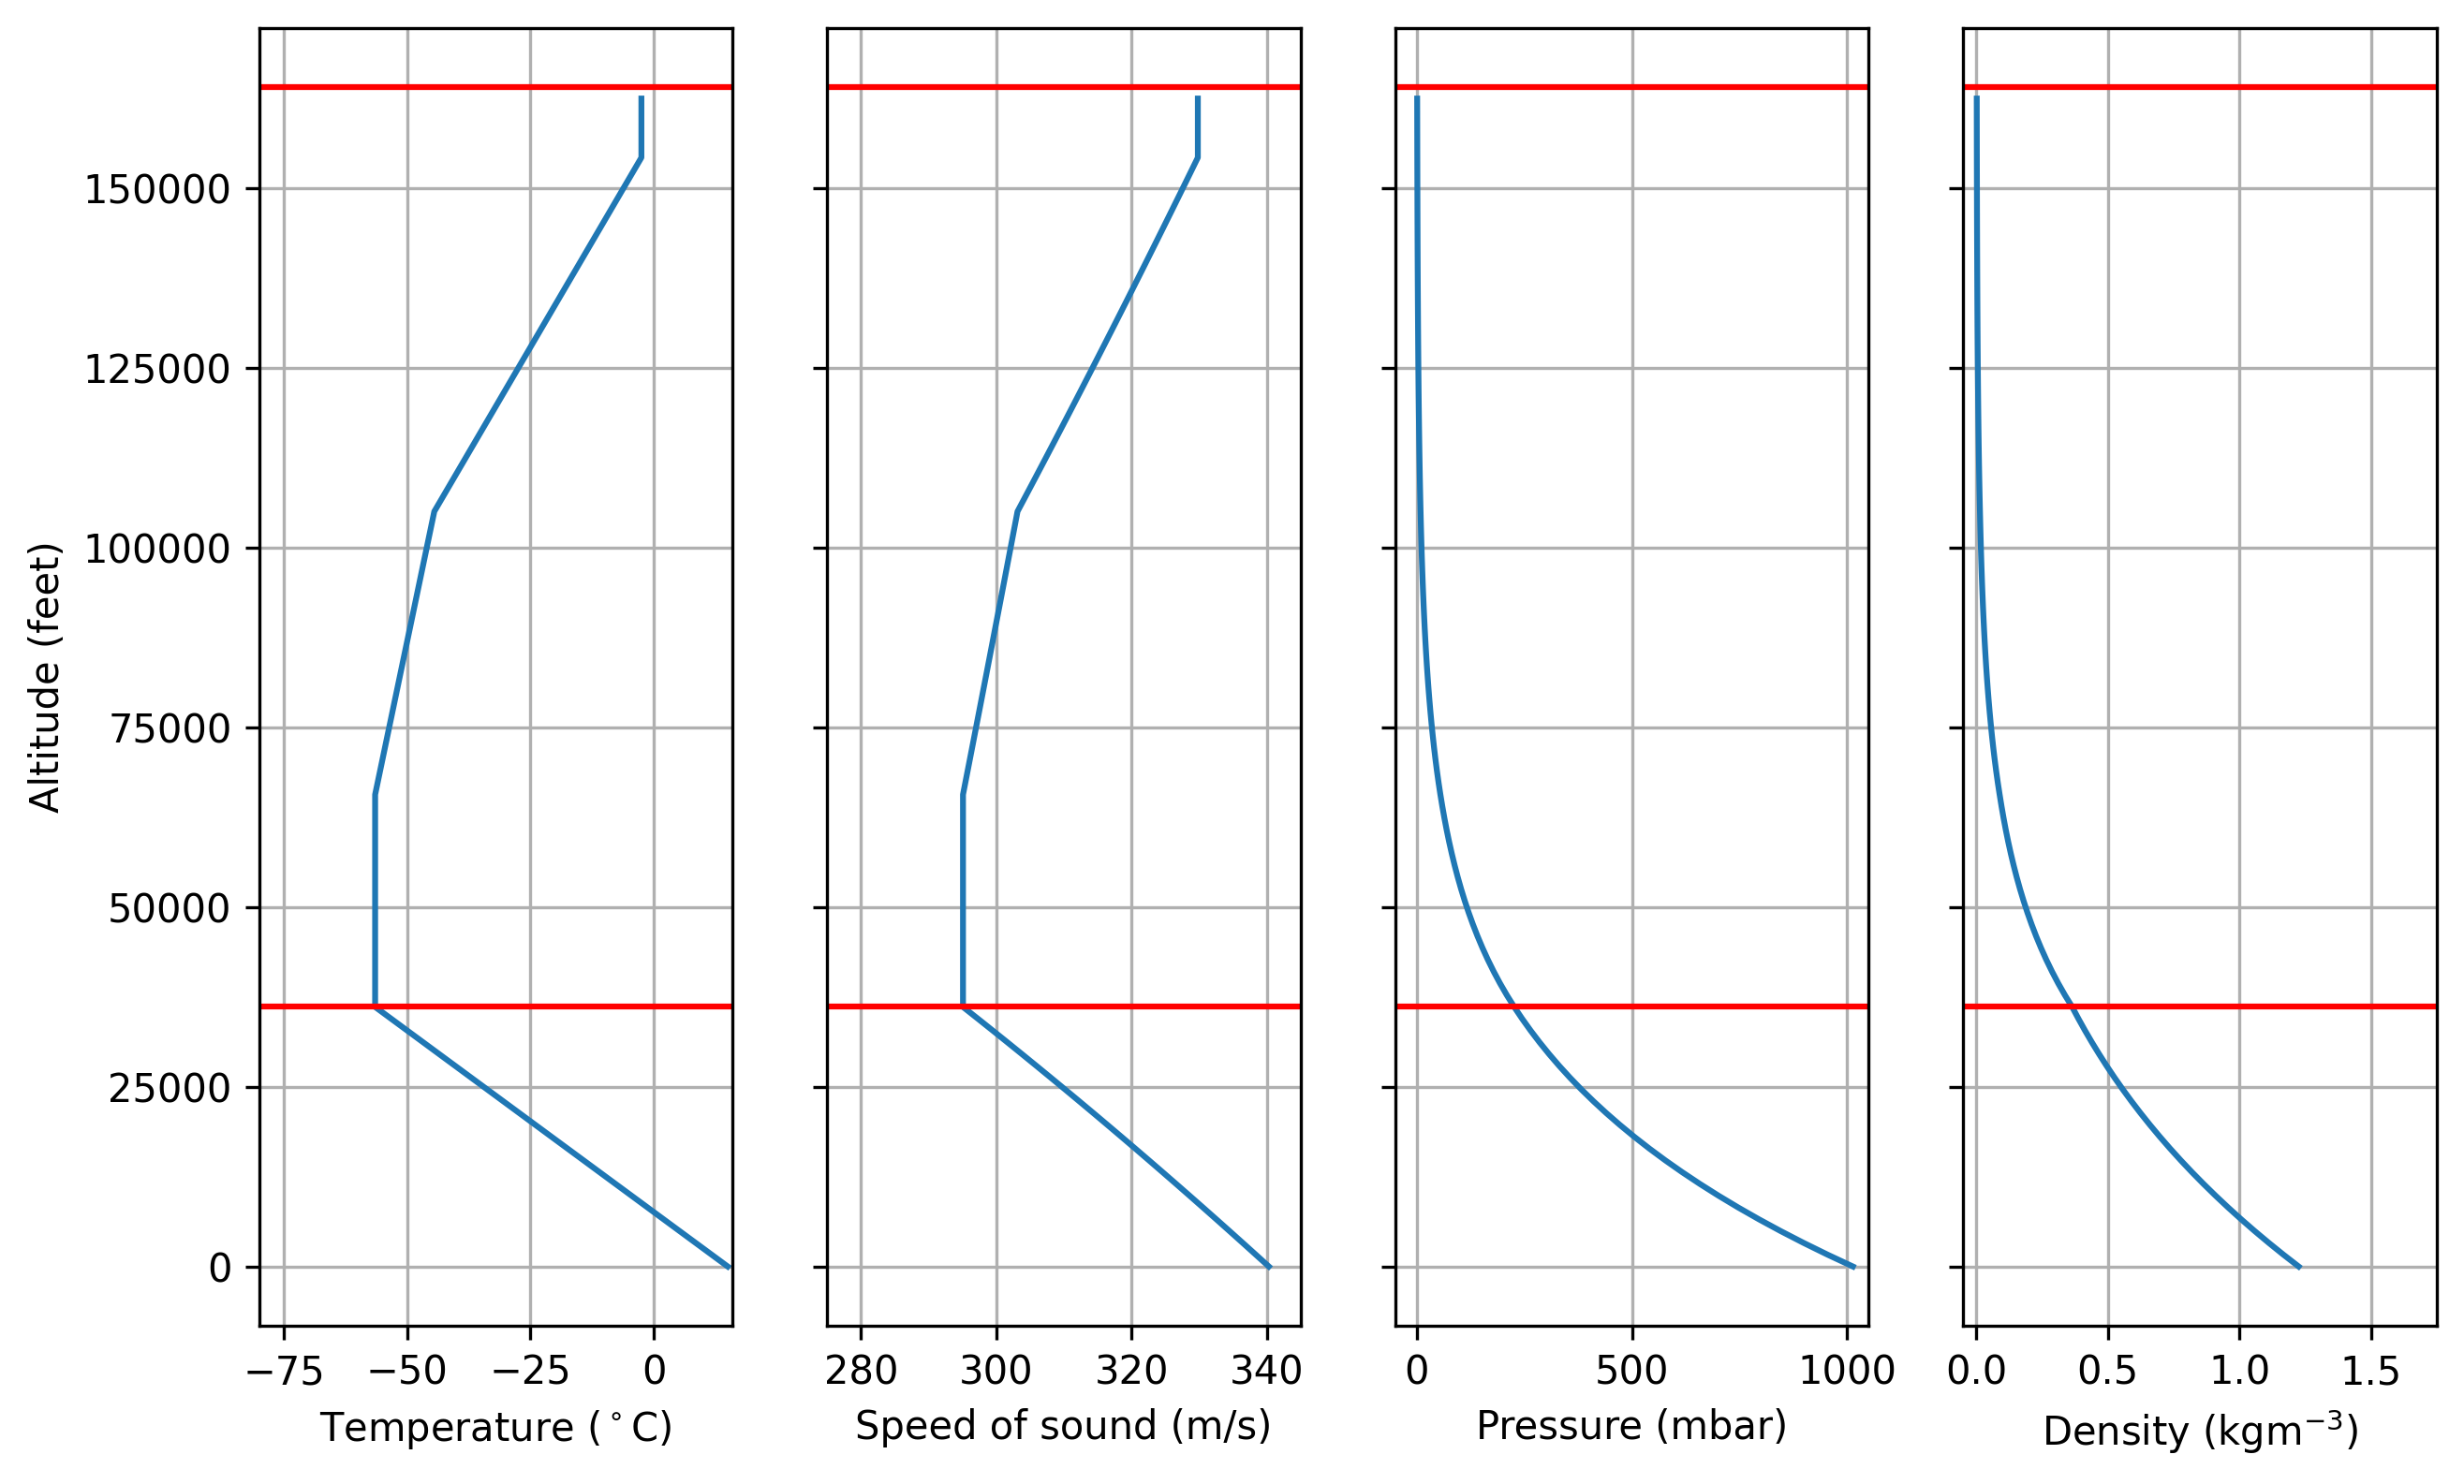

In [10]:
f, axes = actools.panelplot_with_shared_y(
    altaxis_ft, [t_isa_c, vs_isa_mps, p_isa_mbar, rho_isa_kgpm3],
    [[-80,16], [275, 345], [-50,1050], [-0.05,1.75]],
    vlabel = 'Altitude (feet)',
    hlabels = ['Temperature ($^\\circ$C)',
               'Speed of sound (m/s)',
               'Pressure (mbar)', 'Density (kgm$^{-3}$)'],
    hlines=[36089, 164042], hlinecols=['red', 'red'],
    figpar=[10, 6, 300], tex=use_tex, fam='sans-serif')

plt.show()

## Non-ISA atmospheres

### The MIL-HDBK-310 atmospheres

This document provides climatic data sets to be used to analyse the performance of miliraty equipment (including aircraft) to be deployed in a certain range of conditions, in certain parts of the world, etc. We will be using atmospheres contained in the document - specifically, 12 atmospheres representing conditions that deviate from ISA.

The `atmospheres` module contains a wrapper called `mil_hdbk_310` that extracts these atmospheres from a digitised version of the data contained in MIL-HDBK-310. It returns two `Obsprofile` class objects, which once initialised, will contain the observational data, as well as interpolators representing the temperature (K), the pressure (Pa), the density (kg/m$^3$) and the speed of sound (m/s) in the given atmosphere. To be specific, the first object will be a one percentile profile from the requested atmosphere, while the second one will be the 10 percentile.

The handbook offers atmospheres featuring unusually high or low values of temperature or density at 5, 10 or 20km (hence the 2 x 2 x 3 = 12 available profiles). These three choices are represented in the header of the `mil_hdbk_310` method as its input arguments.

For example, to obtain the 1 and 10 percentiles of the atmosphere that features atypically low temperatures at an altitude of 5km, we call `mil_hdbk_310` as follows:

In [11]:
resolution_m = 100

isa = at.Atmosphere()

altaxis_m  = np.arange(0, 50000, resolution_m)
altaxis_ft = uc.m_ft(altaxis_m)

t_isa_c = isa.airtemp_c(altaxis_m)
vs_isa_mps = isa.vsound_mps(altaxis_m)
p_isa_mbar = isa.airpress_mbar(altaxis_m)
rho_isa_kgpm3 = isa.airdens_kgpm3(altaxis_m)

In [12]:
low5profile1pct, low5profile10pct = at.mil_hdbk_310('low', 'temp', 5)

We can now create atmosphere objects with these profiles:

In [13]:
atm5kcold1pct = at.Atmosphere(profile=low5profile1pct)

In [14]:
atm5kcold10pct = at.Atmosphere(profile=low5profile10pct)

Let us now create atmospheres representing unusually *high* temperatures at 5km:

In [15]:
high5profile1pct, high5profile10pct = at.mil_hdbk_310('high', 'temp', 5)

In [16]:
atm5kwarm1pct = at.Atmosphere(profile=high5profile1pct)

In [17]:
atm5kwarm10pct = at.Atmosphere(profile=high5profile10pct)

We can now plot these atmospheres against the same altitude axis as we used above for the ISA:

In [18]:
t5kcold1pct_c = atm5kcold1pct.airtemp_c(altaxis_m)
vs5kcold1pct_mps = atm5kcold1pct.vsound_mps(altaxis_m)
p5kcold1pct_mbar = atm5kcold1pct.airpress_mbar(altaxis_m)
rho5kcold1pct_kgpm3 = atm5kcold1pct.airdens_kgpm3(altaxis_m)

In [19]:
t5kwarm1pct_c = atm5kwarm1pct.airtemp_c(altaxis_m)
vs5kwarm1pct_mps = atm5kwarm1pct.vsound_mps(altaxis_m)
p5kwarm1pct_mbar = atm5kwarm1pct.airpress_mbar(altaxis_m)
rho5kwarm1pct_kgpm3 = atm5kwarm1pct.airdens_kgpm3(altaxis_m)

In [20]:
t5kcold10pct_c = atm5kcold10pct.airtemp_c(altaxis_m)
vs5kcold10pct_mps = atm5kcold10pct.vsound_mps(altaxis_m)
p5kcold10pct_mbar = atm5kcold10pct.airpress_mbar(altaxis_m)
rho5kcold10pct_kgpm3 = atm5kcold10pct.airdens_kgpm3(altaxis_m)

In [21]:
t5kwarm10pct_c = atm5kwarm10pct.airtemp_c(altaxis_m)
vs5kwarm10pct_mps = atm5kwarm10pct.vsound_mps(altaxis_m)
p5kwarm10pct_mbar = atm5kwarm10pct.airpress_mbar(altaxis_m)
rho5kwarm10pct_kgpm3 = atm5kwarm10pct.airdens_kgpm3(altaxis_m)

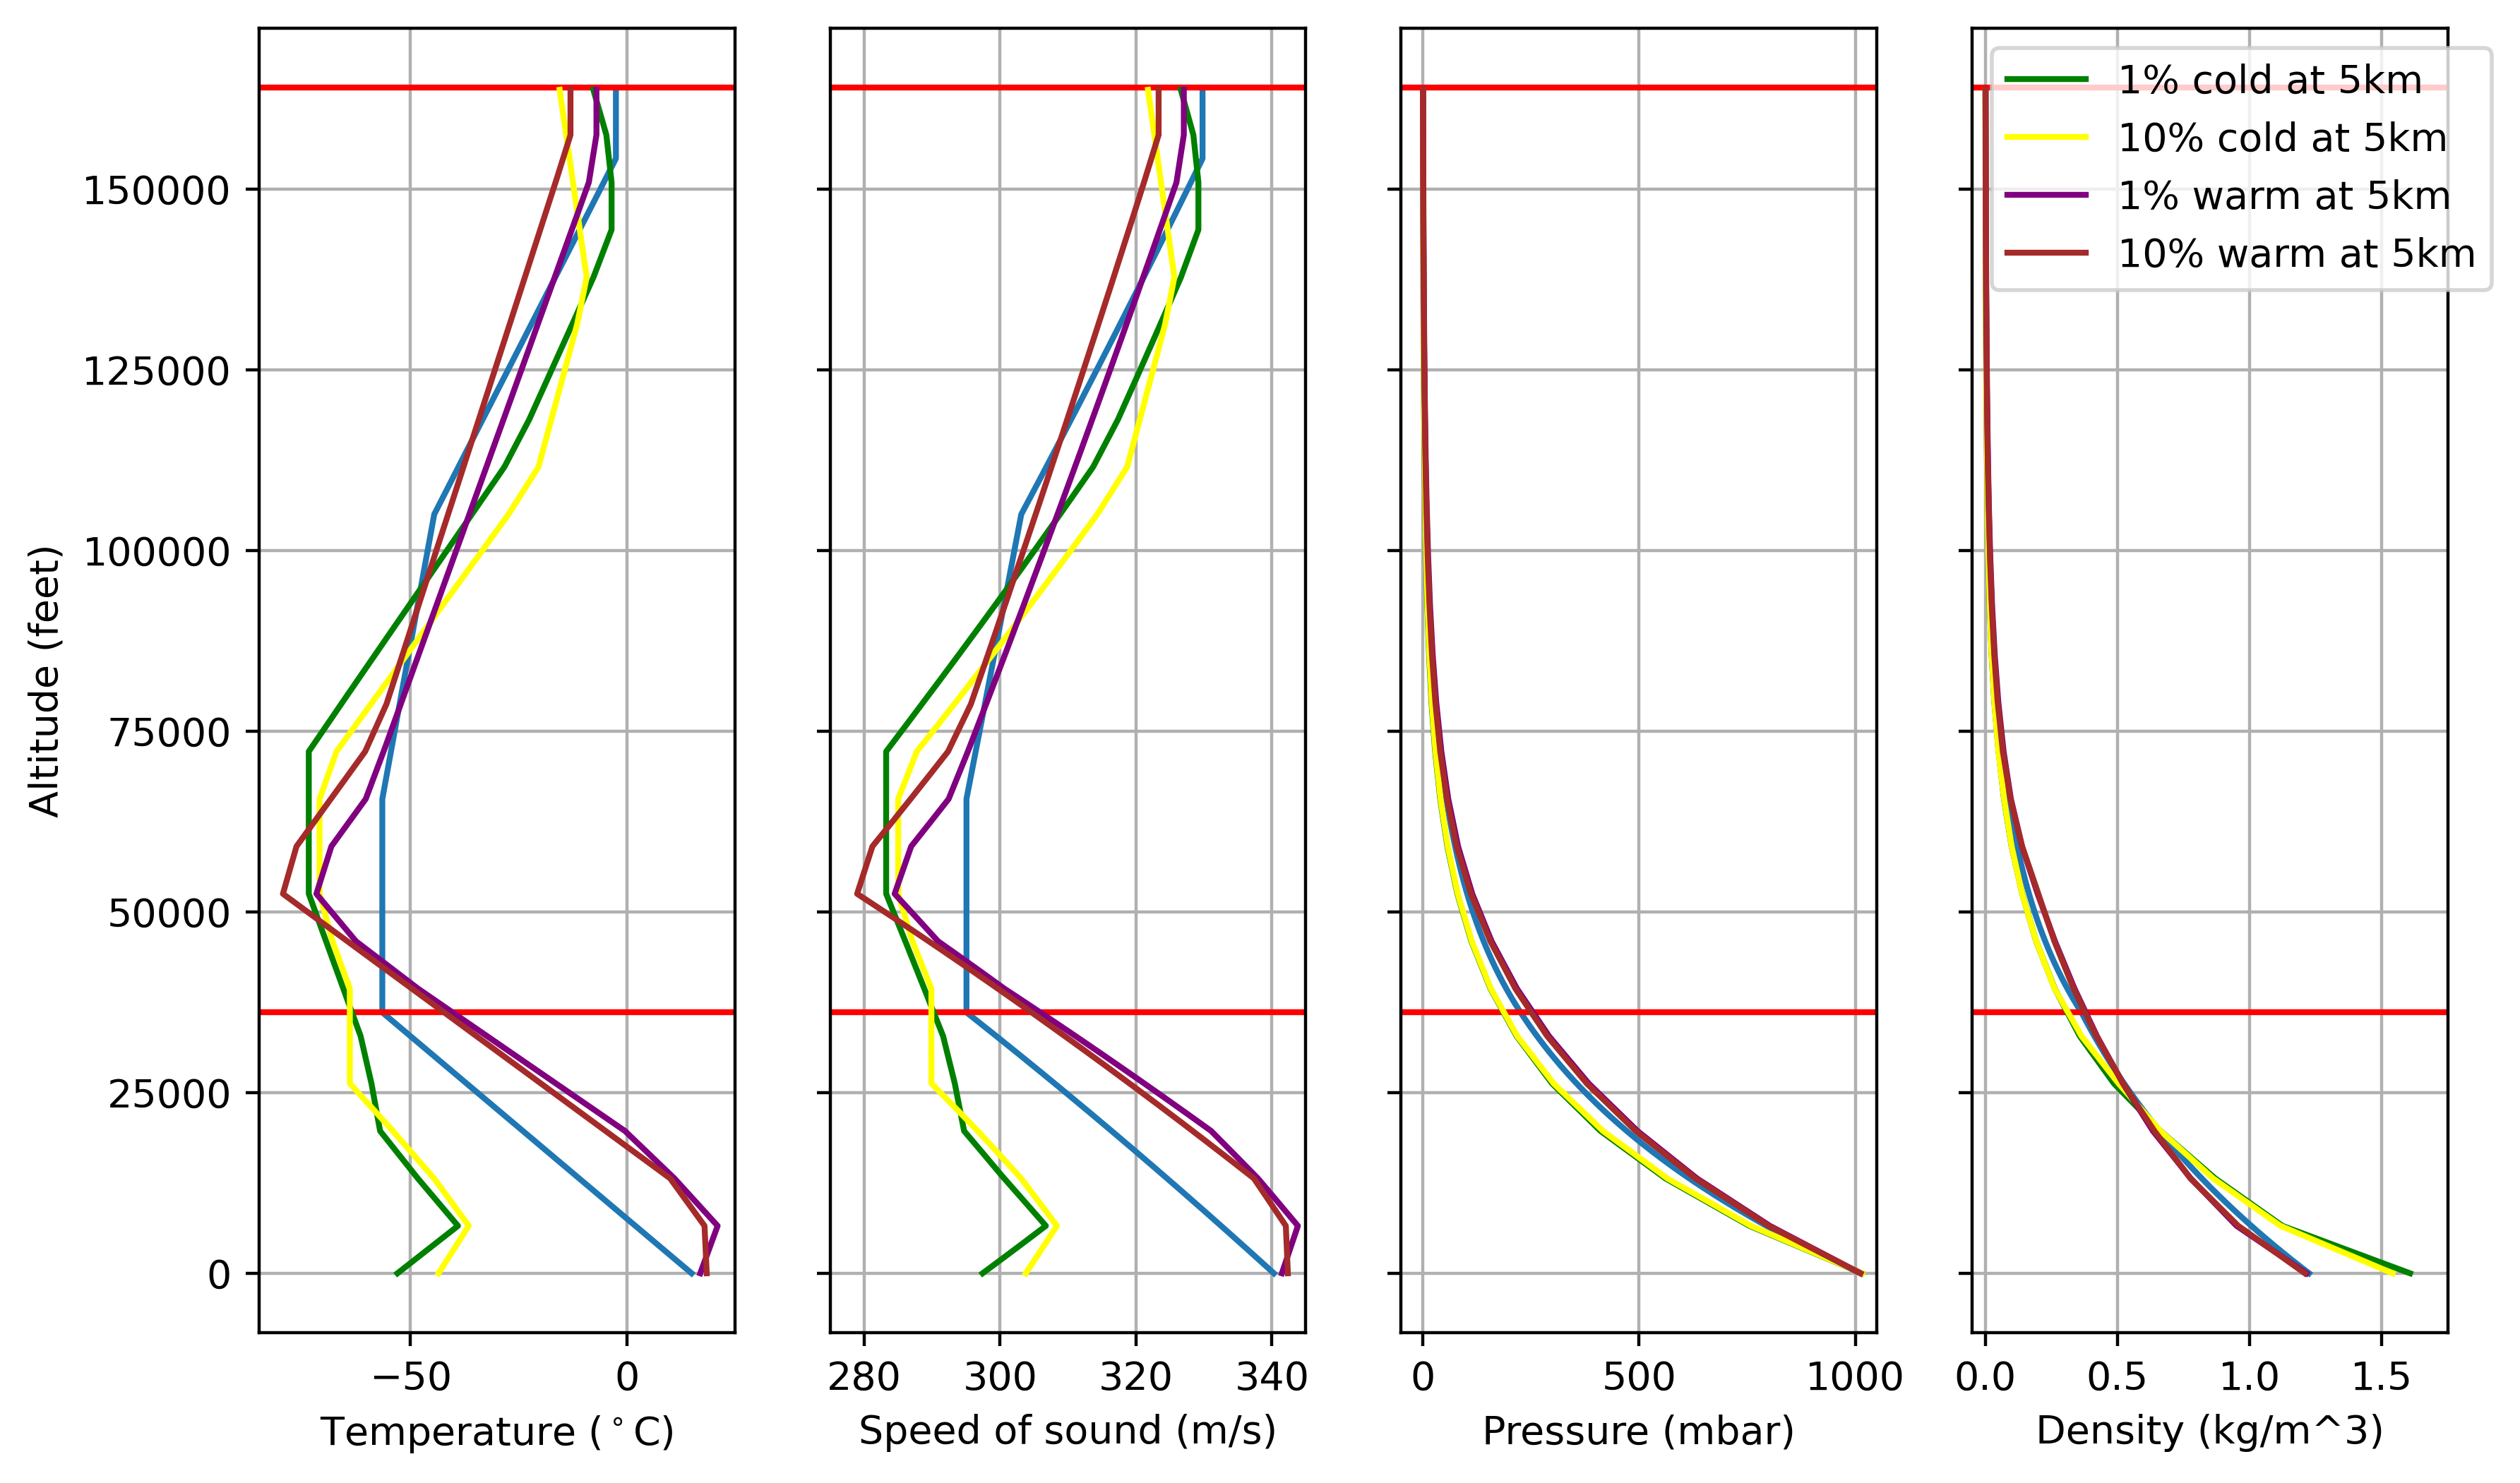

In [22]:
f, axes = actools.panelplot_with_shared_y(
    altaxis_ft, [t_isa_c, vs_isa_mps, p_isa_mbar, rho_isa_kgpm3],
    [[-85,25], [275, 345], [-50,1050], [-0.05,1.75]],
    vlabel = 'Altitude (feet)',
    hlabels = ['Temperature ($^\\circ$C)',
               'Speed of sound (m/s)',
               'Pressure (mbar)', 'Density (kg/m^3)'],
    hlines=[36089, 164042], hlinecols=['red', 'red'], figpar=[10, 6, 400],
    tex=use_tex, fam='sans-serif')


# 1 percentile cold at 5km
axes[0].plot(t5kcold1pct_c,altaxis_ft,'green')
axes[1].plot(vs5kcold1pct_mps,altaxis_ft,'green')
axes[2].plot(p5kcold1pct_mbar,altaxis_ft,'green')
axes[3].plot(rho5kcold1pct_kgpm3,altaxis_ft,'green', label = '1% cold at 5km')

# 10 percentile cold at 5km
axes[0].plot(t5kcold10pct_c,altaxis_ft,'yellow')
axes[1].plot(vs5kcold10pct_mps,altaxis_ft,'yellow')
axes[2].plot(p5kcold10pct_mbar,altaxis_ft,'yellow')
axes[3].plot(rho5kcold10pct_kgpm3,altaxis_ft,'yellow', label = '10% cold at 5km')

# 1 percentile warm at 5km
axes[0].plot(t5kwarm1pct_c,altaxis_ft,'purple')
axes[1].plot(vs5kwarm1pct_mps,altaxis_ft,'purple')
axes[2].plot(p5kwarm1pct_mbar,altaxis_ft,'purple')
axes[3].plot(rho5kwarm1pct_kgpm3,altaxis_ft,'purple', label = '1% warm at 5km')

# 10 percentile warm at 5km
axes[0].plot(t5kwarm10pct_c,altaxis_ft,'brown')
axes[1].plot(vs5kwarm10pct_mps,altaxis_ft,'brown')
axes[2].plot(p5kwarm10pct_mbar,altaxis_ft,'brown')
axes[3].plot(rho5kwarm10pct_kgpm3,altaxis_ft,'brown', label = '10% warm at 5km')

legend = axes[3].legend(loc='best')

plt.show()

### Building an atmosphere model from an observed profile

You could take your own profile data - you need temperature and pressure profiles like those in MIL-HDBK-310 - and create your own atmosphere. As above, you can first create `Obsprofile` class objects and then you can build an `Atmosphere` class object that works exactly as in the example above.